Задачу look-a-like будем решать на примере поиска сегмента клиентов, склонных к оттоку из некого банка. Датасет содержит ретро-данные о клиентах, оттекших из банка - целевой сегмент. Аналогично - имеются данные о тех, кто не оттек. Необходимо для любого другого клиента из тестовой выборки определить вероятность (склонность к оттоку).

**Задача**: построить модель классификации с предельно большим значением ROC-AUC

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling


# Загрузка и подготовка данных

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# заранее установим в константу random_state
random_state = 47

sns.set(style="whitegrid")

In [45]:
churn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/Churn_Modelling.csv')
print(churn.shape)
churn.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**

- Exited — факт ухода клиента

Сразу исключим ненужные столбцы, чтобы модели не переобучались под пользователей:

In [47]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
churn.head()

KeyError: "['RowNumber', 'CustomerId', 'Surname'] not found in axis"

## Визуализация

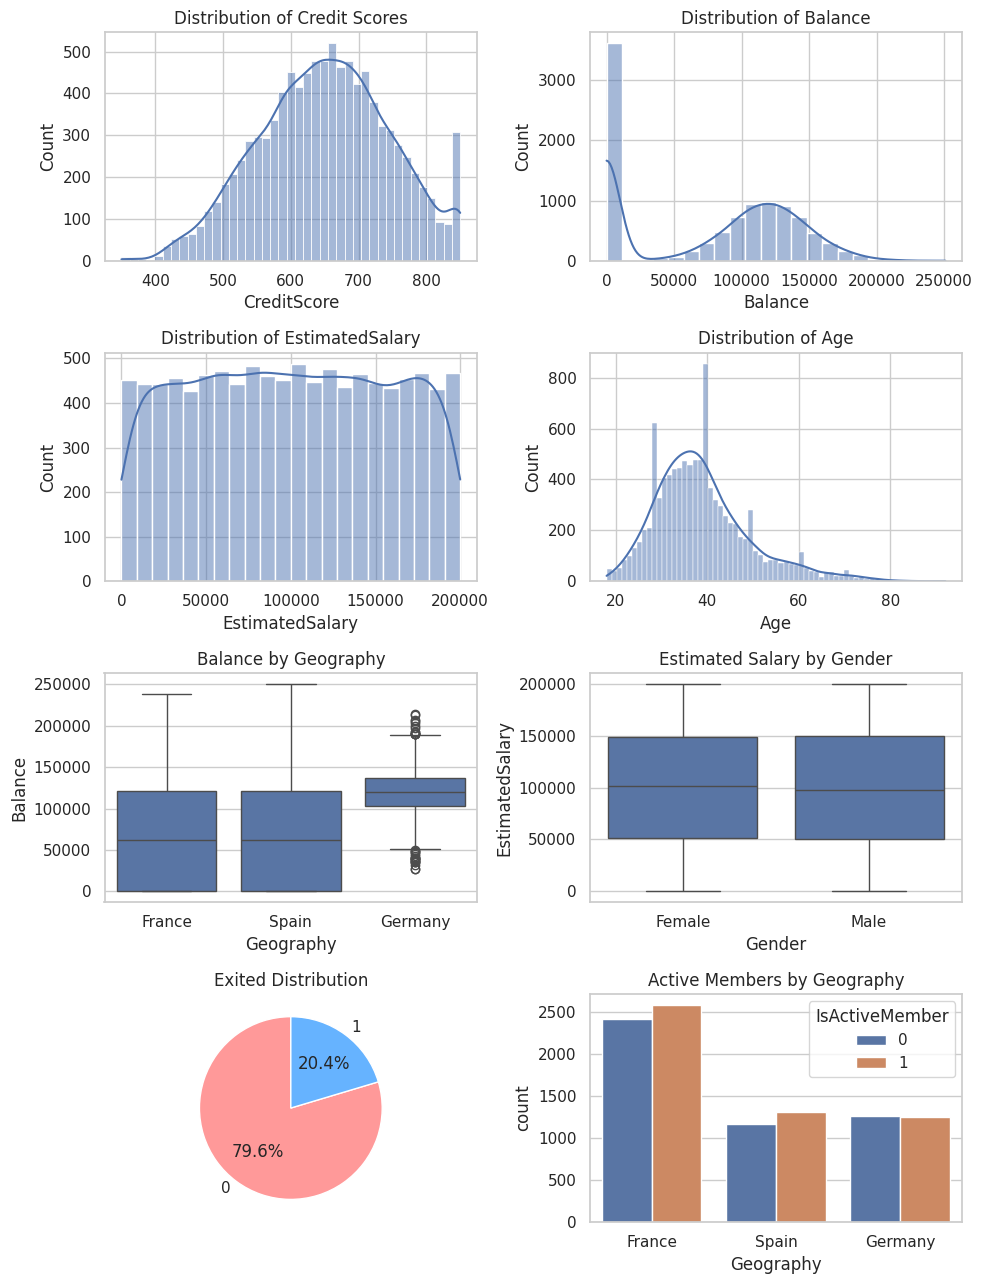

In [48]:
# Создание подграфиков
fig, axes = plt.subplots(4, 2, figsize=(10, 13))

# Гистограмма кредитных баллов
sns.histplot(data=churn, x='CreditScore', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Credit Scores')

# Гистограмма баланса на счёте
sns.histplot(data=churn, x='Balance', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Balance')

# Гистограмма зарплат
sns.histplot(data=churn, x='EstimatedSalary', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of EstimatedSalary')

# Гистограмма возраста
sns.histplot(data=churn, x='Age', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Age')

# Боксплот баланса по странам
sns.boxplot(x='Geography', y='Balance', data=churn, ax=axes[2, 0])
axes[2, 0].set_title('Balance by Geography')

# Боксплот зарплаты по полу
sns.boxplot(x='Gender', y='EstimatedSalary', data=churn, ax=axes[2, 1])
axes[2, 1].set_title('Estimated Salary by Gender')

# Круговая диаграмма для колонки Exited
exited_counts = churn['Exited'].value_counts()
axes[3, 0].pie(exited_counts, labels=exited_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
axes[3, 0].set_title('Exited Distribution')

# Распределение активных членов по странам
sns.countplot(x='Geography', hue='IsActiveMember', data=churn, ax=axes[3, 1])
axes[3, 1].set_title('Active Members by Geography')

# Подгонка и отображение графиков
plt.tight_layout()
plt.show()

## Кодирование

В данных есть категориальные и количественные признаки. Без кодировщика не обойтись.

Далее будем обучать следующие модели: логистическую регрессию, SVM, решающее дерево, случайный лес и бустинг. Ко всему датасету применим One-Hot и будем использовать для всех моделей.

In [49]:
# One-Hot для логрега (для зелени тоже подходит)
churn = pd.get_dummies(churn, drop_first=True)
print(churn.shape)
churn.head()

(10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


## Семплирование

Делим на выборки:

In [50]:
features = churn.drop(['Exited'], axis=1)
target = churn['Exited']

In [51]:
# мощность классов
target.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [52]:
target.mean()

0.2037

In [53]:
# отделяем 20% - пятую часть всего - на тестовую выборку
X_train_valid, X_test, y_train_valid, y_test = train_test_split(features, target,
                                                                            test_size=0.2,
                                                                            random_state=random_state)
# отделяем 25% - четвертую часть трейн+валид - на валидирующую выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                                              test_size=0.25,
                                                                              random_state=random_state)

s1 = y_train.size
s2 = y_valid.size
s3 = y_test.size
print('Разбиение на выборки train:valid:test в соотношении '
      + str(round(s1/s3)) + ':' + str(round(s2/s3)) + ':' + str(round(s3/s3)))

Разбиение на выборки train:valid:test в соотношении 3:1:1


In [54]:
targets = [y_train, y_train_valid, y_valid, y_test]
names = ['train:', 'train+valid:', 'valid:', 'test:']
print('Баланс классов на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

Баланс классов на разбиениях:

train: 0.20116666666666666
train+valid: 0.20175
valid: 0.2035
test: 0.2115


## Масштабирование

Среди моделей, выбранных для исследования, есть линейные. Качество линейных алгоритмов зависит от масштаба данных. Признаки должны быть нормализованы. Если масштаб одного признака сильно превосходит масштаб других, то качество может резко упасть. Для нормализации используем стандартизацию признаков: возьмем набор значений признака на всех объектах, вычислим их среднее значение и стандартное отклонение. После этого из всех значений признака вычтем среднее, и затем полученную разность поделим на стандартное отклонение. Сделает это StandardScaler()...

In [55]:
# Выделяем количественные признаки для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Параметры стандартизации получим на трейне
scaler = StandardScaler()
scaler.fit(X_train[numeric])

# Преобразуем все выборки на основе параметров, полученных выше
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train_valid[numeric] = scaler.fit_transform(X_train_valid[numeric])

In [56]:
X_train[numeric].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03
mean,5.027090e-16,1.160553e-16,1.101341e-16,-1.657933e-17,-5.210647e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-3.135540e+00,-1.993557e+00,-1.729935e+00,-1.236119e+00,-1.752577e+00
25%,-6.903947e-01,-6.625224e-01,-6.946312e-01,-1.236119e+00,-8.596568e-01
50%,6.731955e-03,-1.871529e-01,-4.428799e-03,3.345666e-01,8.692727e-03
75%,6.934537e-01,4.783642e-01,1.030875e+00,8.205161e-01,8.550975e-01
max,2.066897e+00,5.041911e+00,1.721077e+00,2.806576e+00,1.729437e+00


Значения по выбранным количественным признакам теперь выглядят немного неадекватно, зато с нулевым средним и среднеквадратичным, равным 1.

# Вспомогательные функции

In [57]:
# Функция для оценки модели
def calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Обучение
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_train)

    # Валидация
    y_valid_pred = model.predict(X_valid)
    y_valid_proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_valid)

    # Тестирование
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    train_metrics = {
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'roc_auc': roc_auc_score(y_train, y_train_proba)
    }

    valid_metrics = {
        'precision': precision_score(y_valid, y_valid_pred),
        'recall': recall_score(y_valid, y_valid_pred),
        'f1': f1_score(y_valid, y_valid_pred),
        'roc_auc': roc_auc_score(y_valid, y_valid_proba)
    }

    test_metrics = {
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }

    return train_metrics, valid_metrics, test_metrics

def print_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    res = calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
    metrics = pd.DataFrame(res, index=['train', 'valid', 'test'])
    return metrics

# Логистическая регрессия

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression

In [58]:
%%time

param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    # 'solver': ['lbfgs', 'liblinear', 'saga'],
    'C': np.linspace(0.001, 2, 50)
}

grid_search = GridSearchCV(LogisticRegression(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_logreg = grid_search.best_estimator_
print(best_logreg.get_params())

{'C': 0.04179591836734694, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
CPU times: user 700 ms, sys: 123 ms, total: 822 ms
Wall time: 11.3 s


In [59]:
res_logreg = print_metrics(best_logreg, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_logreg

,precision,recall,f1,roc_auc
train,0.615190,0.201326,0.303371,0.774375
valid,0.617391,0.174447,0.272031,0.764587
test,0.643939,0.200946,0.306306,0.754336


In [60]:
# Получение коэффициентов модели
coef = best_logreg.coef_[0]

# Создание DataFrame для коэффициентов и признаков
coef_df = pd.DataFrame({
    'Feature': X_train_valid.columns,
    'Coefficient_logreg': coef
})

# Добавление столбца с интерпретацией
coef_df['Interpretation_logreg'] = coef_df['Coefficient_logreg'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

**Positive**: Если коэффициент положительный, это означает, что увеличение значения признака увеличивает вероятность положительного исхода.

**Negative**: Если коэффициент отрицательный, это означает, что увеличение значения признака уменьшает вероятность положительного исхода.

In [61]:
coef_df

,Feature,Coefficient_logreg,Interpretation_logreg
0,CreditScore,-0.064229,Negative
1,Age,0.738354,Positive
2,Tenure,-0.031604,Negative
3,Balance,0.169131,Positive
4,NumOfProducts,-0.127850,Negative
5,HasCrCard,-0.019065,Negative
6,IsActiveMember,-0.974834,Negative
7,EstimatedSalary,0.046965,Positive
8,Geography_Germany,0.706719,Positive
9,Geography_Spain,0.020639,Positive


# SVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [62]:
%%time

param_grid = {
    # 'C': np.linspace(0.001, 2, 50),
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'kernel': ['linear', 'poly']

}

grid_search = GridSearchCV(SVC(random_state=42, probability=True, gamma='scale'),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_SVC = grid_search.best_estimator_
print(best_SVC.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
CPU times: user 12.6 s, sys: 494 ms, total: 13 s
Wall time: 1min 22s


In [63]:
res_SVC = print_metrics(best_SVC, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_SVC

,precision,recall,f1,roc_auc
train,0.856322,0.246893,0.383280,0.824915
valid,0.884956,0.245700,0.384615,0.840966
test,0.850000,0.241135,0.375691,0.811978


https://scikit-learn.org/stable/modules/permutation_importance.html

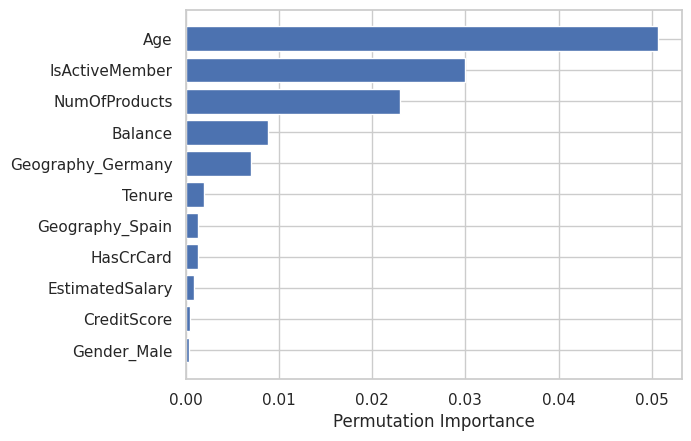

In [64]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_SVC, X_test, y_test)

features = np.array(X_test.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

# Решающее дерево

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [65]:
%%time

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    # 'splitter': ['best', 'random'],
    'max_depth': range(1, 11),
    # 'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10)
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train_valid, y_train_valid)

best_tree = grid_search.best_estimator_
print(best_tree.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
CPU times: user 1.52 s, sys: 242 ms, total: 1.76 s
Wall time: 38.3 s


In [66]:
res_tree = print_metrics(best_tree, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_tree

,precision,recall,f1,roc_auc
train,0.766710,0.484673,0.593909,0.867659
valid,0.813043,0.459459,0.587127,0.869227
test,0.744000,0.439716,0.552749,0.841452


In [67]:
def plot_importance(model, X):
  # Получение важности признаков
  feature_importances = model.feature_importances_

  # Создание DataFrame для важности признаков
  importance_df = pd.DataFrame({
      'Feature': X.columns,
      'Importance': feature_importances
  })

  # Сортировка DataFrame по важности
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  # Визуализация важности признаков
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Importance', y='Feature', data=importance_df)
  plt.title('Feature Importances in Decision Tree')
  plt.show()

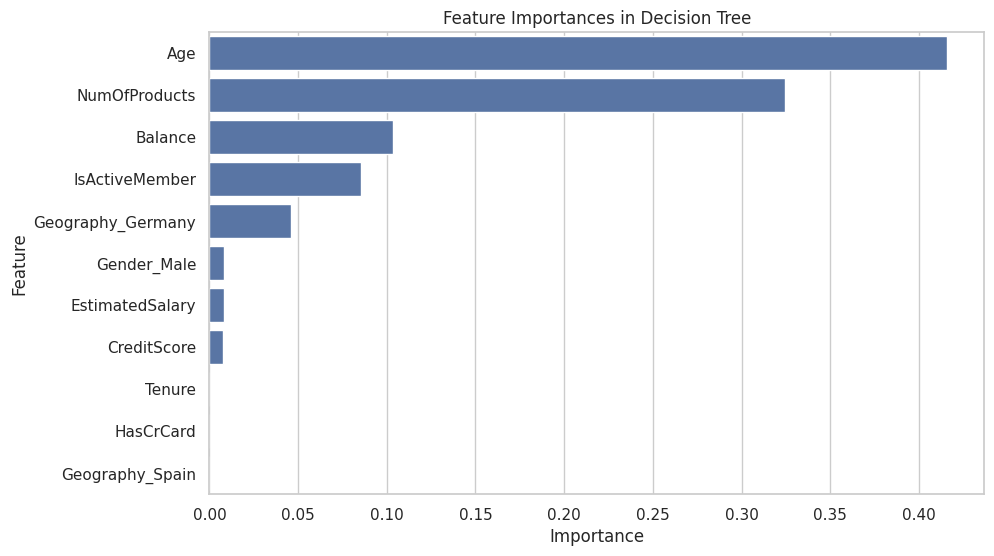

In [68]:
plot_importance(best_tree, X_train_valid)

In [69]:
from sklearn.tree import export_graphviz
import graphviz

def plot_tree(model, name, X):
  # Визуализация дерева решений
  dot_data = export_graphviz(
      model,
      out_file=None,
      feature_names=X.columns,
      class_names=['Stayed', 'Exited'],
      filled=True,
      rounded=True,
      special_characters=True
  )

  # Создание графика дерева
  graph = graphviz.Source(dot_data)
  graph.render(name)

  # Отображение дерева
  graph.view()

In [70]:
plot_tree(best_tree, 'decision_tree', X_train_valid)

# Случайный лес

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [71]:
!pip install optuna

In [72]:
import optuna

In [73]:
def objective(trial):
    param = {
        'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
        'n_estimators': trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 10), # сократить кол-во деревьев
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10),

    }

    model = RandomForestClassifier(**param, random_state=random_state)
    model.fit(X_train, y_train)

    preds = model.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, preds)

    return auc

In [74]:
study = optuna.create_study(direction="maximize", study_name='RandomForestClassifier')
study.optimize(objective, n_trials=10) # попробовать увеличить

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-11 18:43:15,175] A new study created in memory with name: RandomForestClassifier
[I 2024-06-11 18:43:16,474] Trial 0 finished with value: 0.8321896626981373 and parameters: {'criterion': 'log_loss', 'n_estimators': 83, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8321896626981373.
[I 2024-06-11 18:43:17,408] Trial 1 finished with value: 0.8277892684672346 and parameters: {'criterion': 'entropy', 'n_estimators': 42, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8321896626981373.
[I 2024-06-11 18:43:18,478] Trial 2 finished with value: 0.8475370594014662 and parameters: {'criterion': 'gini', 'n_estimators': 40, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8475370594014662.
[I 2024-06-11 18:43:19,751] Trial 3 finished with value: 0.8340081221437153 and parameters: {'criterion': 'entropy', 'n_estimators': 85, 'max_depth': 3, 'min_sampl

Number of finished trials: 10
Best trial:
Value: 0.8563710089133817
Params: 
    criterion: entropy
    n_estimators: 98
    max_depth: 9
    min_samples_split: 3
    min_samples_leaf: 6


In [75]:
best_forest = RandomForestClassifier(**study.best_params, random_state=random_state)
best_forest.fit(X_train_valid, y_train_valid)

res_forest = print_metrics(best_forest, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_forest

,precision,recall,f1,roc_auc
train,0.874613,0.468103,0.609822,0.920749
valid,0.893519,0.474201,0.619583,0.916692
test,0.780822,0.404255,0.532710,0.860162


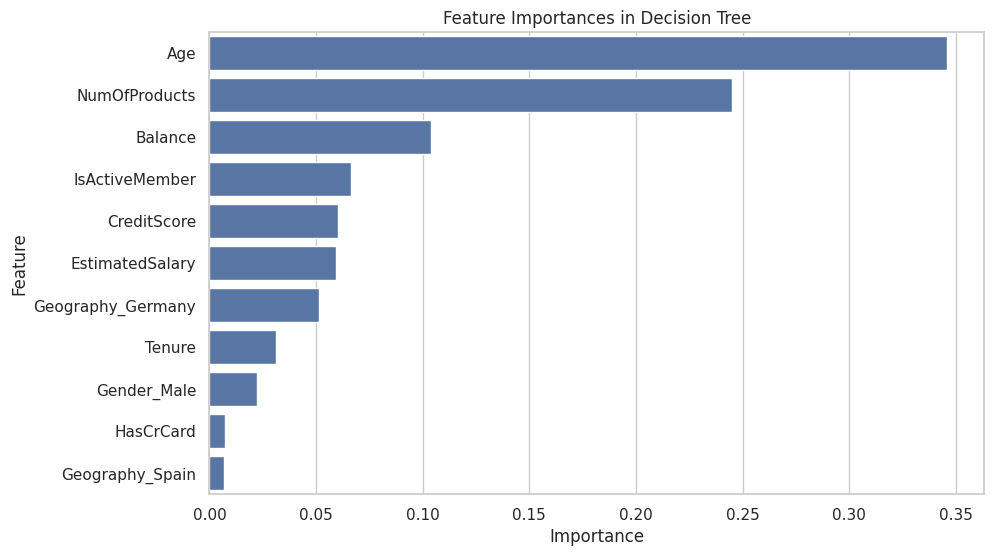

In [76]:
plot_importance(best_forest, X_train_valid)

In [77]:
plot_tree(best_forest.estimators_[2], 'random_forest_tree', X_train_valid)

# CatBoostClassifier

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier

In [78]:
!pip install catboost

In [79]:
from catboost import CatBoostClassifier

In [95]:
def objective(trial):
    param = {
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.9),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "l2_leaf_reg":trial.suggest_float('l2_leaf_reg', 0.01, 2),
        "subsample": trial.suggest_float('subsample', 0.01, 1),
        "random_strength": trial.suggest_float('random_strength', 1, 200),
        "min_data_in_leaf":trial.suggest_float('min_data_in_leaf', 1, 500)
    }

    cat = CatBoostClassifier(
        logging_level="Silent",
        eval_metric="AUC",
        grow_policy="Lossguide",
        random_seed=42,
        **param)
    cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
            early_stopping_rounds=10
           )

    preds = cat.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, preds)

    return auc

In [96]:
study = optuna.create_study(direction="maximize", study_name='CatBoostClassifier')
study.optimize(objective, n_trials=100) # попробуйте увеличить

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-11 19:27:28,154] A new study created in memory with name: CatBoostClassifier
[I 2024-06-11 19:27:29,024] Trial 0 finished with value: 0.840159111345552 and parameters: {'learning_rate': 0.07685097704677187, 'max_depth': 10, 'l2_leaf_reg': 1.9852823745810848, 'subsample': 0.6465910938316582, 'random_strength': 154.47251726227273, 'min_data_in_leaf': 215.55224857812777}. Best is trial 0 with value: 0.840159111345552.
[I 2024-06-11 19:27:29,238] Trial 1 finished with value: 0.8472278133295081 and parameters: {'learning_rate': 0.4117588440957875, 'max_depth': 4, 'l2_leaf_reg': 0.17340998861687118, 'subsample': 0.8391444509786121, 'random_strength': 51.21039104396646, 'min_data_in_leaf': 249.87552500643307}. Best is trial 1 with value: 0.8472278133295081.
[I 2024-06-11 19:27:29,916] Trial 2 finished with value: 0.8348194110905973 and parameters: {'learning_rate': 0.059914743350335406, 'max_depth': 10, 'l2_leaf_reg': 1.755649577965136, 'subsample': 0.6778713315459138, 'random_stre

Number of finished trials: 100
Best trial:
Value: 0.8597842835130971
Params: 
    learning_rate: 0.301177218541556
    max_depth: 4
    l2_leaf_reg: 1.1039516168921955
    subsample: 0.818302863501161
    random_strength: 110.25458851327664
    min_data_in_leaf: 285.4993185654668


In [97]:
best_cat = CatBoostClassifier(**study.best_params, random_state=random_state)
best_cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
             early_stopping_rounds=10
           )

res_cat = print_metrics(best_cat, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_cat

,precision,recall,f1,roc_auc
train,0.812414,0.487987,0.609731,0.887651
valid,0.807018,0.452088,0.579528,0.854224
test,0.770492,0.444444,0.563718,0.862123


https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

In [83]:
!pip install shap

In [84]:
import shap
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer(X_train_valid)

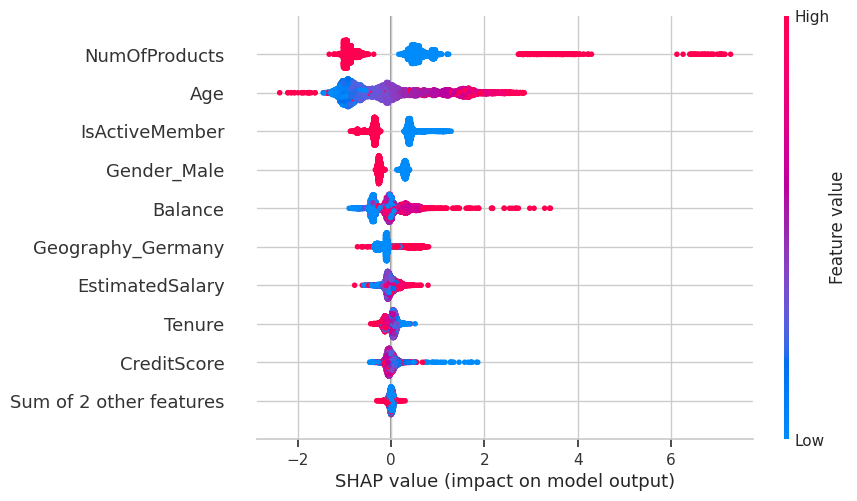

In [85]:
shap.plots.beeswarm(shap_values)